# 1.数据总览

Titanic 生存模型预测，其中包含了两组数据：train.csv 和 test.csv，分别为训练集合和测试集合。

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

观察前几行的源数据：

In [2]:
train_data = pd.read_csv('C:/Users/刘明瑶/Desktop/data/train.csv')
test_data = pd.read_csv('C:/Users/刘明瑶/Desktop/data/test.csv')

sns.set_style('whitegrid')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


数据信息总览

In [3]:
train_data.info()
print("-" * 40)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

从上面我们可以看出，Age、Cabin、Embarked、Fare几个特征存在缺失值。

绘制存活的比例：

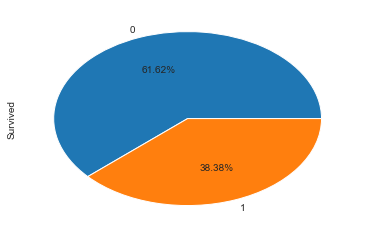

In [4]:
train_data['Survived'].value_counts().plot.pie(autopct = '%1.2f%%')

# 2.缺失值处理的方法

对数据进行分析的时候要注意其中是否有缺失值。

一些机器学习算法能够处理缺失值，比如神经网络，一些则不能。对于缺失值，一般有以下几种处理方法：

（1）如果数据集很多，但有很少的缺失值，可以删掉带缺失值的行；

（2）如果该属性相对学习来说不是很重要，可以对缺失值赋均值或者众数。比如在哪儿上船Embarked这一属性（共有三个上船地点），缺失俩值，可以用众数赋值；

In [5]:
train_data.Embarked[train_data.Embarked.isnull()] = train_data.Embarked.dropna().mode().values

（3）对于标称属性，可以赋一个代表缺失的值，比如‘U0’。因为缺失本身也可能代表着一些隐含信息。比如船舱号Cabin这一属性，缺失可能代表并没有船舱。

In [6]:
#用U0来替换缺失值
train_data['Cabin'] = train_data.Cabin.fillna('U0') # train_data.Cabin[train_data.Cabin.isnull()]='U0'

（4）使用回归 随机森林等模型来预测缺失属性的值。因为Age在该数据集里是一个相当重要的特征（先对Age进行分析即可得知），所以保证一定的缺失值填充准确率是非常重要的，对结果也会产生较大影响。一般情况下，会使用数据完整的条目作为模型的训练集，以此来预测缺失值。对于当前的这个数据，可以使用随机森林来预测也可以使用线性回归预测。这里使用随机森林预测模型，选取数据集中的数值属性作为特征（因为sklearn的模型只能处理数值属性，所以这里先仅选取数值特征，但在实际的应用中需要将非数值特征转换为数值特征）

In [7]:
from sklearn.ensemble import RandomForestRegressor

#choose training data to predict age
age_df = train_data[['Age','Survived','Fare', 'Parch', 'SibSp', 'Pclass']]
age_df_notnull = age_df.loc[(train_data['Age'].notnull())]
age_df_isnull = age_df.loc[(train_data['Age'].isnull())]
X = age_df_notnull.values[:,1:]
Y = age_df_notnull.values[:,0]
# use RandomForestRegression to train data
RFR = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RFR.fit(X,Y)
predictAges = RFR.predict(age_df_isnull.values[:,1:])
train_data.loc[train_data['Age'].isnull(), ['Age']]= predictAges

让我们再来看一下缺失数据处理后的DataFram：

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


# 3.分析数据关系

## (1) 性别与是否生存的关系 Sex

In [9]:
train_data.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

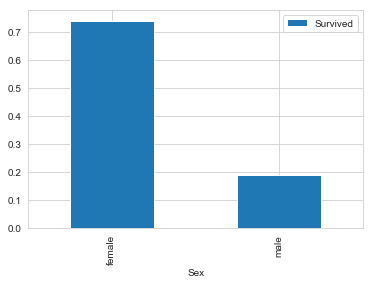

In [10]:
train_data[['Sex','Survived']].groupby(['Sex']).mean().plot.bar()

以上为不同性别的生存率，可见在泰坦尼克号事故中，还是体现了Lady First。

## (2) 船舱等级和生存与否的关系 Pclass

In [11]:
train_data.groupby(['Pclass','Survived'])['Pclass'].count()

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Pclass, dtype: int64

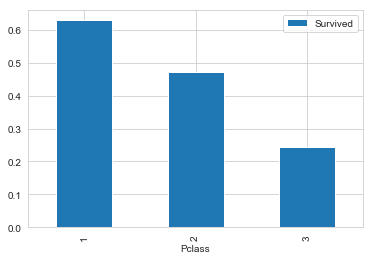

In [12]:
train_data[['Pclass','Survived']].groupby(['Pclass']).mean().plot.bar()

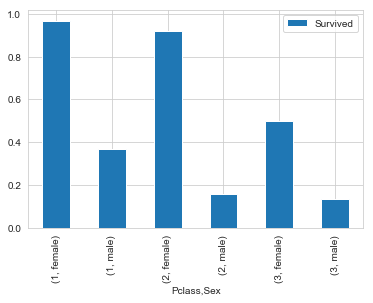

In [13]:
train_data[['Sex','Pclass','Survived']].groupby(['Pclass','Sex']).mean().plot.bar()

不同等级船舱的男女生存率：

In [14]:
train_data.groupby(['Sex', 'Pclass', 'Survived'])['Survived'].count()

Sex     Pclass  Survived
female  1       0             3
                1            91
        2       0             6
                1            70
        3       0            72
                1            72
male    1       0            77
                1            45
        2       0            91
                1            17
        3       0           300
                1            47
Name: Survived, dtype: int64

从图和表中可以看出，总体上泰坦尼克号逃生是妇女优先，但是对于不同等级的船舱还是有一定的区别。

## (3) 年龄与存活与否的关系 Age

分别分析不同等级船舱和不同性别下的年龄分布和生存的关系：

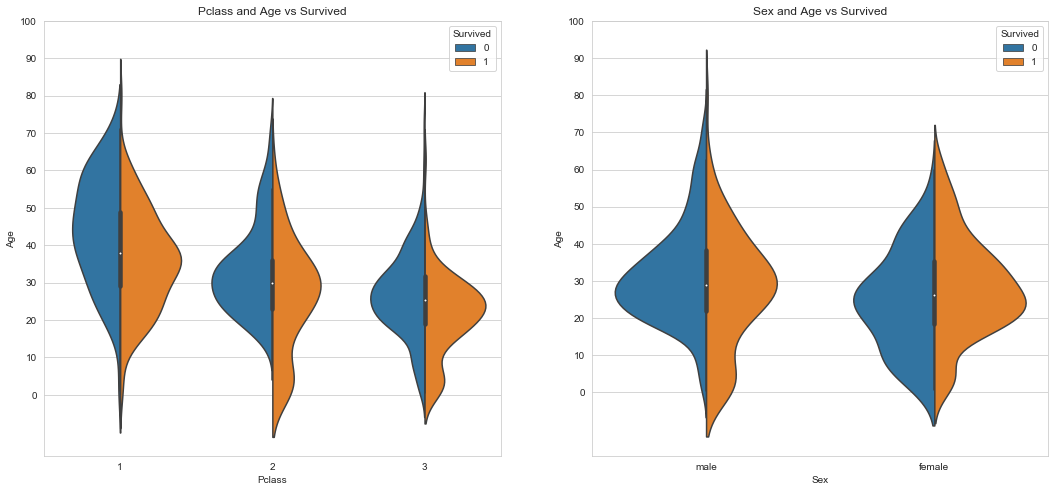

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))
sns.violinplot("Pclass", "Age", hue="Survived", data=train_data, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

sns.violinplot("Sex", "Age", hue="Survived", data=train_data, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()

分析总体的年龄分布：

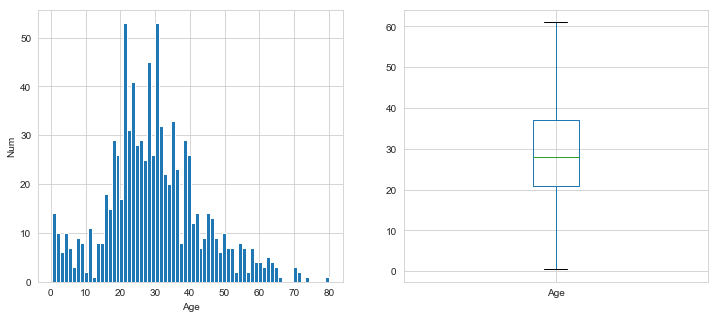

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(121)
train_data['Age'].hist(bins=70)
plt.xlabel('Age')
plt.ylabel('Num')

plt.subplot(122)
train_data.boxplot(column='Age', showfliers=False)
plt.show()

不同年龄下的生存和非生存的分布情况：

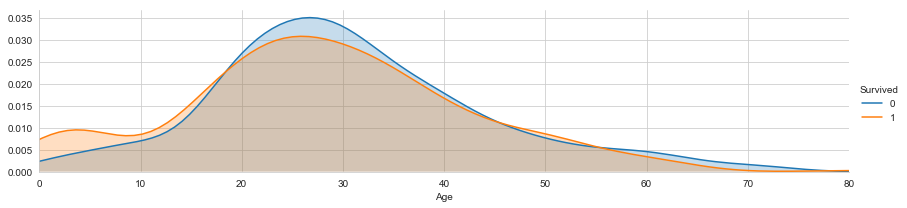

In [17]:
facet = sns.FacetGrid(train_data, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_data['Age'].max()))
facet.add_legend()

不同年龄下的平均生存率：

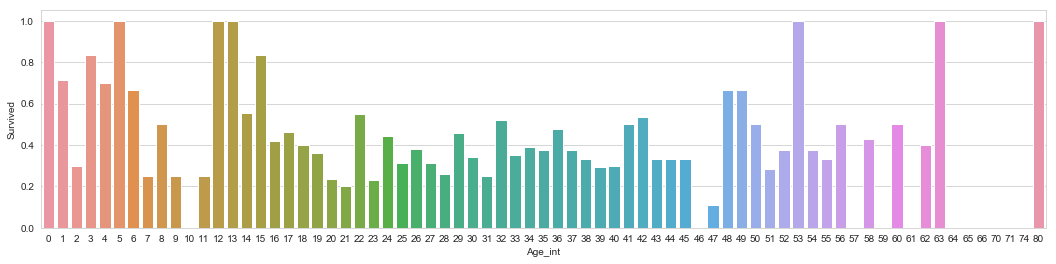

In [18]:
# average survived passengers by age
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data["Age_int"] = train_data["Age"].astype(int)
average_age = train_data[["Age_int", "Survived"]].groupby(['Age_int'],as_index=False).mean()
sns.barplot(x='Age_int', y='Survived', data=average_age)

In [19]:
train_data['Age'].describe()

count    891.000000
mean      29.657604
std       13.735052
min        0.420000
25%       21.000000
50%       28.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

样本有891，平均年龄约为30岁，标准差13.5岁，最小年龄为0.42，最大年龄80.

按照年龄，将乘客划分为儿童、少年、成年和老年，分析四个群体的生还情况：

In [20]:
bins = [0, 12, 18, 65, 100]
train_data['Age_group'] = pd.cut(train_data['Age'], bins)
by_age = train_data.groupby('Age_group')['Survived'].mean()
by_age

Age_group
(0, 12]      0.506173
(12, 18]     0.466667
(18, 65]     0.364512
(65, 100]    0.125000
Name: Survived, dtype: float64

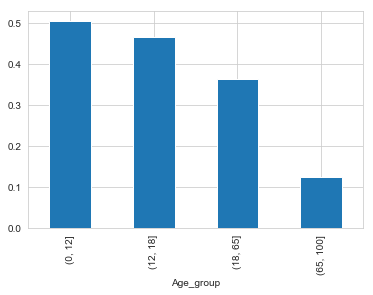

In [21]:
by_age.plot(kind = 'bar')

## (4) 称呼与存活与否的关系 Name

通过观察名字数据，我们可以看出其中包括对乘客的称呼，如：Mr、Miss、Mrs等，称呼信息包含了乘客的年龄、性别，同时也包含了如社会地位等的称呼，如：Dr,、Lady、Major、Master等的称呼。

In [22]:
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_data['Title'], train_data['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


观察不同称呼与生存率的关系：

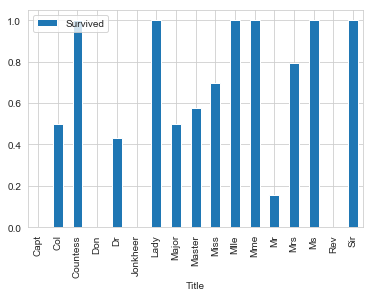

In [23]:
train_data[['Title','Survived']].groupby(['Title']).mean().plot.bar()

同时，对于名字，我们还可以观察名字长度和生存率之间存在关系的可能：

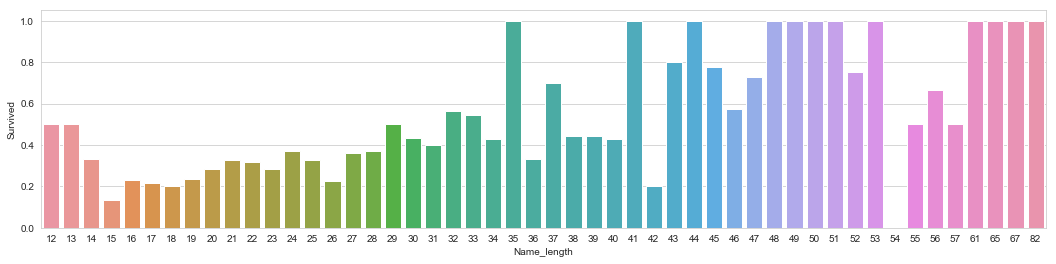

In [24]:
fig, axis1 = plt.subplots(1,1,figsize=(18,4))
train_data['Name_length'] = train_data['Name'].apply(len)
name_length = train_data[['Name_length','Survived']].groupby(['Name_length'],as_index=False).mean()
sns.barplot(x='Name_length', y='Survived', data=name_length)

从上面的图片可以看出，名字长度和生存与否确实也存在一定的相关性。

## (5) 有无兄弟姐妹和存活与否的关系 SibSp

In [25]:
# 将数据分为有兄弟姐妹的和没有兄弟姐妹的两组：
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]

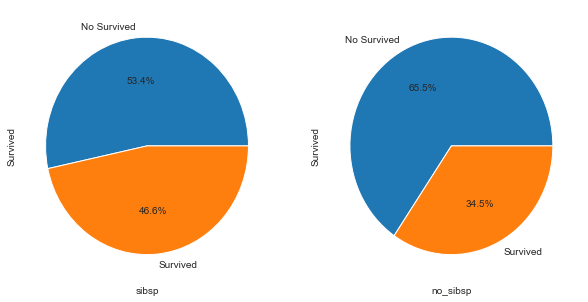

In [26]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('sibsp')

plt.subplot(122)
no_sibsp_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_sibsp')

plt.show()

## (6) 有无父母子女和存活与否的关系 Parch

和有无兄弟姐妹一样，同样分析可以得到：

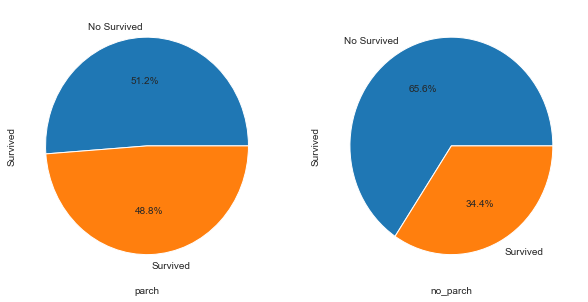

In [27]:
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]

plt.figure(figsize=(10,5))
plt.subplot(121)
parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('parch')

plt.subplot(122)
no_parch_df['Survived'].value_counts().plot.pie(labels=['No Survived', 'Survived'], autopct = '%1.1f%%')
plt.xlabel('no_parch')

plt.show()

## (7) 亲友的人数和存活与否的关系 SibSp & Parch

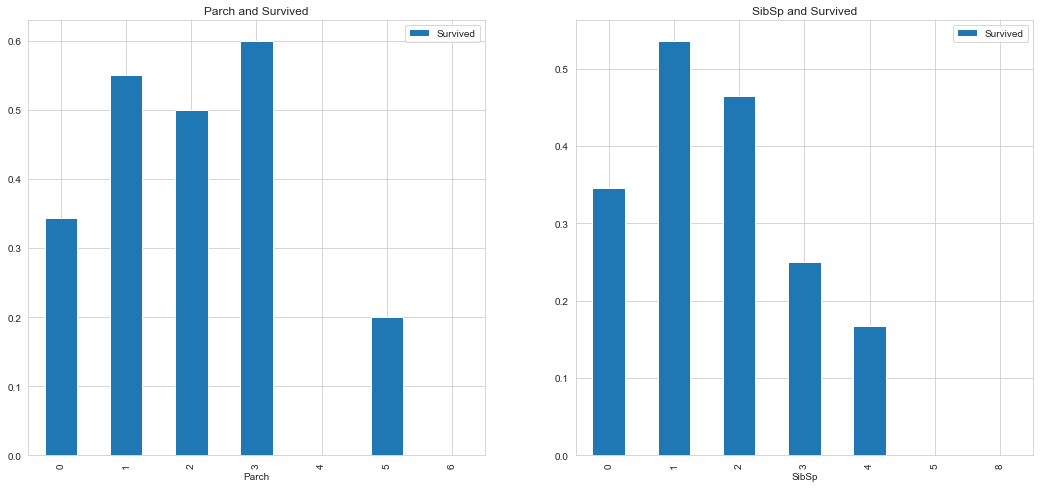

In [28]:
fig,ax=plt.subplots(1,2,figsize=(18,8))
train_data[['Parch','Survived']].groupby(['Parch']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Parch and Survived')
train_data[['SibSp','Survived']].groupby(['SibSp']).mean().plot.bar(ax=ax[1])
ax[1].set_title('SibSp and Survived')

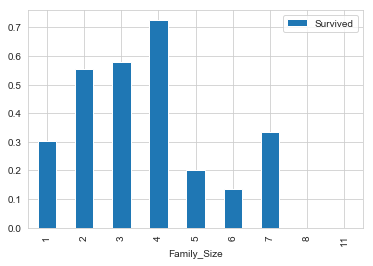

In [29]:
train_data['Family_Size'] = train_data['Parch'] + train_data['SibSp'] + 1
train_data[['Family_Size','Survived']].groupby(['Family_Size']).mean().plot.bar()

从图表中可以看出，若独自一人，那么其存活率比较低；但是如果亲友太多的话，存活率也会很低。

## (8) 票价分布和存活与否的关系 Fare

首先绘制票价的分布情况：

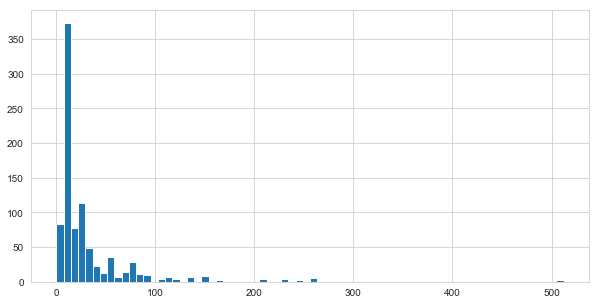

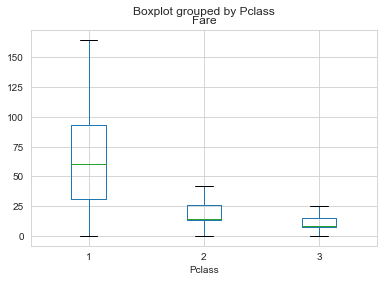

In [30]:
plt.figure(figsize=(10,5))
train_data['Fare'].hist(bins = 70)

train_data.boxplot(column='Fare', by='Pclass', showfliers=False)
plt.show()

In [31]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

绘制生存与否与票价均值和方差的关系：

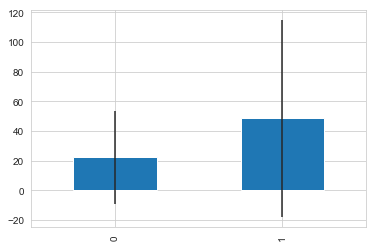

In [32]:
fare_not_survived = train_data['Fare'][train_data['Survived'] == 0]
fare_survived = train_data['Fare'][train_data['Survived'] == 1]

average_fare = pd.DataFrame([fare_not_survived.mean(), fare_survived.mean()])
std_fare = pd.DataFrame([fare_not_survived.std(), fare_survived.std()])
average_fare.plot(yerr=std_fare, kind='bar', legend=False)

plt.show()

由上图标可知，票价与是否生还有一定的相关性，生还者的平均票价要大于未生还者的平均票价。

## (9) 船舱类型和存活与否的关系 Cabin

由于船舱的缺失值确实太多，有效值仅仅有204个，很难分析出不同的船舱和存活的关系，所以在做特征工程的时候，可以直接将该组特征丢弃。

当然，这里我们也可以对其进行一下分析，对于缺失的数据都分为一类。

简单地将数据分为是否有Cabin记录作为特征，与生存与否进行分析：

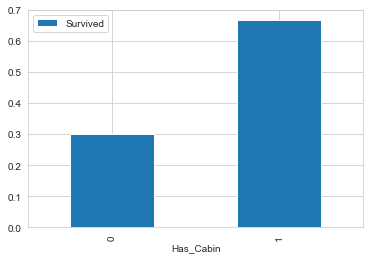

In [33]:
# Replace missing values with "U0"
train_data.loc[train_data.Cabin.isnull(), 'Cabin'] = 'U0'
train_data['Has_Cabin'] = train_data['Cabin'].apply(lambda x: 0 if x == 'U0' else 1)
train_data[['Has_Cabin','Survived']].groupby(['Has_Cabin']).mean().plot.bar()

对不同类型的船舱进行分析：

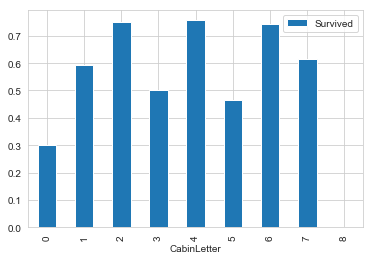

In [34]:
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]
train_data[['CabinLetter','Survived']].groupby(['CabinLetter']).mean().plot.bar()

可见，不同的船舱生存率也有不同，但是差别不大。所以在处理中，我们可以直接将特征删除。

## (10) 港口和存活与否的关系 Embarked

泰坦尼克号从英国的南安普顿港出发，途径法国瑟堡和爱尔兰昆士敦，那么在昆士敦之前上船的人，有可能在瑟堡或昆士敦下船，这些人将不会遇到海难。

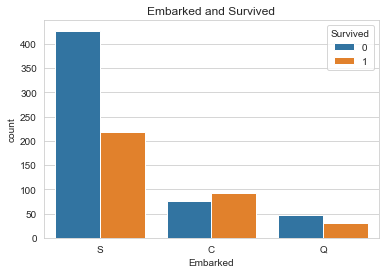

In [35]:
sns.countplot('Embarked', hue='Survived', data=train_data)
plt.title('Embarked and Survived')

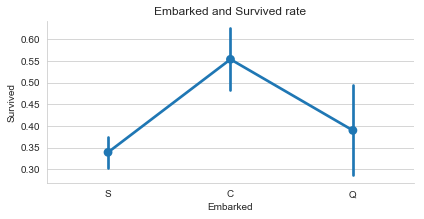

In [36]:
sns.factorplot('Embarked', 'Survived', data=train_data, size=3, aspect=2)
plt.title('Embarked and Survived rate')
plt.show()

由上可以看出，在不同的港口上船，生还率不同，C最高，Q次之，S最低。

以上为所给出的数据特征与生还与否的分析。

据了解，泰坦尼克号上共有2224名乘客。本训练数据只给出了891名乘客的信息，如果该数据集是从总共的2224人中随机选出的，根据中心极限定理，该样本的数据也足够大，那么我们的分析结果就具有代表性；但如果不是随机选取，那么我们的分析结果就可能不太靠谱了。

## (11) 其他可能和存活与否有关系的特征

对于数据集中没有给出的特征信息，我们还可以联想其他可能会对模型产生影响的特征因素。如：乘客的国籍、乘客的身高、乘客的体重、乘客是否会游泳、乘客职业等等。

另外还有数据集中没有分析的几个特征：Ticket（船票号）、Cabin（船舱号）,这些因素的不同可能会影响乘客在船中的位置从而影响逃生的顺序。但是船舱号数据缺失，船票号类别大，难以分析规律，所以在后期模型融合的时候，将这些因素交由模型来决定其重要性。

# 4. 变量转换

变量转换的目的是将数据转换为适用于模型使用的数据，不同模型接受不同类型的数据，Scikit-learn要求数据都是数字型numeric，所以我们要将一些非数字型的原始数据转换为数字型numeric。

所以下面对数据的转换进行介绍，以在进行特征工程的时候使用。

所有的数据可以分为两类：

1.定性(Quantitative)变量可以以某种方式排序，Age就是一个很好的列子。
2.定量(Qualitative)变量描述了物体的某一（不能被数学表示的）方面，Embarked就是一个例子。

## 定性(Qualitative)转换：

### 1. Dummy Variables

就是类别变量或者二元变量，当qualitative variable是一些频繁出现的几个独立变量时，Dummy Variables比较适合使用。我们以Embarked为例，Embarked只包含三个值’S’,’C’,’Q’，我们可以使用下面的代码将其转换为dummies:

In [37]:
embark_dummies  = pd.get_dummies(train_data['Embarked'])
train_data = train_data.join(embark_dummies)
train_data.drop(['Embarked'], axis=1,inplace=True)

In [38]:
embark_dummies = train_data[['S', 'C', 'Q']]
embark_dummies.head()

,S,C,Q
0,1,0,0
1,0,1,0
2,1,0,0
3,1,0,0
4,1,0,0


### 2. Factorizing

dummy不好处理Cabin（船舱号）这种标称属性，因为他出现的变量比较多。所以Pandas有一个方法叫做factorize()，它可以创建一些数字，来表示类别变量，对每一个类别映射一个ID，这种映射最后只生成一个特征，不像dummy那样生成多个特征。

In [39]:
# Replace missing values with "U0"
train_data['Cabin'][train_data.Cabin.isnull()] = 'U0'
# create feature for the alphabetical part of the cabin number
train_data['CabinLetter'] = train_data['Cabin'].map( lambda x : re.compile("([a-zA-Z]+)").search(x).group())
# convert the distinct cabin letters with incremental integer values
train_data['CabinLetter'] = pd.factorize(train_data['CabinLetter'])[0]

In [40]:
train_data['CabinLetter'].head()

0    0
1    1
2    0
3    1
4    0
Name: CabinLetter, dtype: int64

## 定量(Quantitative)转换：

### 1. Scaling

Scaling可以将一个很大范围的数值映射到一个很小的范围(通常是-1 - 1，或则是0 - 1)，很多情况下我们需要将数值做Scaling使其范围大小一样，否则大范围数值特征将会由更高的权重。比如：Age的范围可能只是0-100，而income的范围可能是0-10000000，在某些对数组大小敏感的模型中会影响其结果。

下面对Age进行Scaling：

In [41]:
from sklearn import preprocessing

assert np.size(train_data['Age']) == 891
# StandardScaler will subtract the mean from each value then scale to the unit variance
scaler = preprocessing.StandardScaler()
train_data['Age_scaled'] = scaler.fit_transform(train_data['Age'].values.reshape(-1, 1))

In [42]:
train_data['Age_scaled'].head()

0   -0.557836
1    0.607721
2   -0.266447
3    0.389179
4    0.389179
Name: Age_scaled, dtype: float64

### 2. Binning

Binning通过观察“邻居”(即周围的值)将连续数据离散化。存储的值被分布到一些“桶”或“箱“”中，就像直方图的bin将数据划分成几块一样。下面的代码对Fare进行Binning。

In [43]:
# Divide all fares into quartiles
train_data['Fare_bin'] = pd.qcut(train_data['Fare'], 5)
train_data['Fare_bin'].head()

0      (-0.001, 7.854]
1    (39.688, 512.329]
2        (7.854, 10.5]
3    (39.688, 512.329]
4        (7.854, 10.5]
Name: Fare_bin, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 39.688] < (39.688, 512.329]]

在将数据Bining化后，要么将数据factorize化，要么dummies化。

In [44]:
# qcut() creates a new variable that identifies the quartile range, but we can't use the string
# so either factorize or create dummies from the result

# factorize
train_data['Fare_bin_id'] = pd.factorize(train_data['Fare_bin'])[0]

# dummies
fare_bin_dummies_df = pd.get_dummies(train_data['Fare_bin']).rename(columns=lambda x: 'Fare_' + str(x))
train_data = pd.concat([train_data, fare_bin_dummies_df], axis=1)

# 5. 特征工程

在进行特征工程的时候，我们不仅需要对训练数据进行处理，还需要同时将测试数据同训练数据一起处理，使得二者具有相同的数据类型和数据分布。

In [45]:
train_df_org = pd.read_csv('C:/Users/刘明瑶/Desktop/data/train.csv')
test_df_org = pd.read_csv('C:/Users/刘明瑶/Desktop/data/test.csv')
test_df_org['Survived'] = 0
combined_train_test = train_df_org.append(test_df_org)
PassengerId = test_df_org['PassengerId']

对数据进行特征工程，也就是从各项参数中提取出对输出结果有或大或小的影响的特征，将这些特征作为训练模型的依据。 一般来说，我们会先从含有缺失值的特征开始。

## (1) Embarked

因为“Embarked”项的缺失值不多，所以这里我们以众数来填充：

In [46]:
combined_train_test['Embarked'].fillna(combined_train_test['Embarked'].mode().iloc[0], inplace=True)

对于三种不同的港口，由上面介绍的数值转换，我们知道可以有两种特征处理方式：dummy和facrorizing。因为只有三个港口，所以我们可以直接用dummy来处理：

In [47]:
# 为了后面的特征分析，这里我们将 Embarked 特征进行facrorizing
combined_train_test['Embarked'] = pd.factorize(combined_train_test['Embarked'])[0]

# 使用 pd.get_dummies 获取one-hot 编码
emb_dummies_df = pd.get_dummies(combined_train_test['Embarked'], prefix=combined_train_test[['Embarked']].columns[0])
combined_train_test = pd.concat([combined_train_test, emb_dummies_df], axis=1)

## (2) Sex

对Sex也进行one-hot编码，也就是dummy处理：

In [48]:
# 为了后面的特征分析，这里我们也将 Sex 特征进行facrorizing
combined_train_test['Sex'] = pd.factorize(combined_train_test['Sex'])[0]

sex_dummies_df = pd.get_dummies(combined_train_test['Sex'], prefix=combined_train_test[['Sex']].columns[0])
combined_train_test = pd.concat([combined_train_test, sex_dummies_df], axis=1)

## (3) Name

首先先从名字中提取各种称呼：

In [49]:
# what is each person's title? 
combined_train_test['Title'] = combined_train_test['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])

将各式称呼进行统一化处理：

In [50]:
title_Dict = {}
title_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
title_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
title_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
title_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
title_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
title_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

combined_train_test['Title'] = combined_train_test['Title'].map(title_Dict)

使用dummy对不同的称呼进行分列：

In [51]:
# 为了后面的特征分析，这里我们也将 Title 特征进行facrorizing
combined_train_test['Title'] = pd.factorize(combined_train_test['Title'])[0]

title_dummies_df = pd.get_dummies(combined_train_test['Title'], prefix=combined_train_test[['Title']].columns[0])
combined_train_test = pd.concat([combined_train_test, title_dummies_df], axis=1)

增加名字长度的特征：

In [52]:
combined_train_test['Name_length'] = combined_train_test['Name'].apply(len)